### Import libraries 

In [7]:
import os
from pathlib import Path
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate
from skimage.exposure import adjust_gamma
import pandas as pd
from sklearn.model_selection import train_test_split

### Input Folder / Dataset folder

In [2]:
input_folder_path = 'data-original'

### Load Data & Create DATAFRAME

- We start by initializing empty lists for storing image paths ('images_list') and their corresponding labels ('labels_list').
- Then for each image in the input folder, its path is constructed. 
- We are keeping only the rgb images not the grayscale ones
- We assign the label about the quality of the fruit 
- Finally, the lists containing image paths and labels are converted into pandas Series and concatenated side by side to form a dataframe. This dataframe structures the dataset in a tabular format, associating each image path with its label, which is a common format for feeding data into machine learning models.

In [ ]:
images_list = []
labels_list = []
    
quality_list = os.listdir(input_folder_path)
    
for quality in quality_list:
    fruit_type = os.listdir(os.path.join(input_folder_path, quality))
    for fruit in fruit_type:
        #if 'Banana' in fruit:
        fruit_path = os.path.join(input_folder_path, quality, fruit)
        images = os.listdir(fruit_path)
        for image in images:
            image_path = os.path.join(fruit_path, image)
            print(image_path)
            i = io.imread(image_path)
            if len(i.shape) == 2 or (len(i.shape) == 3 and i.shape[2] == 1):
                print(f"Grayscale {image_path}")
                continue  
            images_list.append(image_path)
            # Check if the image name contains '_Good' or '_Bad' and assign the label accordingly
            if "_Good" in fruit or "_Bad" in fruit:
                labels_list.append(f"{fruit}")
            else:
                labels_list.append(f"{fruit}_Mixed")
                    
images_series = pd.Series(images_list, name="images_paths")
labels_series = pd.Series(labels_list, name="labels")
df = pd.concat([images_series, labels_series], axis=1)


Print dataframe

In [4]:
df

,images_paths,labels
0,data-original\Bad Quality_Fruits\Apple_Bad\IMG...,Apple_Bad
1,data-original\Bad Quality_Fruits\Apple_Bad\IMG...,Apple_Bad
2,data-original\Bad Quality_Fruits\Apple_Bad\IMG...,Apple_Bad
3,data-original\Bad Quality_Fruits\Apple_Bad\IMG...,Apple_Bad
4,data-original\Bad Quality_Fruits\Apple_Bad\IMG...,Apple_Bad
...,...,...
18318,data-original\Mixed Qualit_Fruits\Pomegranate\...,Pomegranate_Mixed
18319,data-original\Mixed Qualit_Fruits\Pomegranate\...,Pomegranate_Mixed
18320,data-original\Mixed Qualit_Fruits\Pomegranate\...,Pomegranate_Mixed
18321,data-original\Mixed Qualit_Fruits\Pomegranate\...,Pomegranate_Mixed


### Print classes distribution

We split the df to train_df and test_df and then we print the distribution. 

As we can see we have class imbalance. Some classes have significant more images than others. 

For example Pomegranate_Good has 3801 images and Apple_Good has 907.

In [5]:
groups = df.groupby('labels')
    
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# For each group, split its data into train and test, then append to train_df and test_df
for label, group in groups:
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_df = pd.concat([train_df, train])
    test_df = pd.concat([test_df, test])

# Shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Checking the balance in the datasets
print("Training set class distribution:")
print(train_df['labels'].value_counts())

print("\nTesting set class distribution:")
print(test_df['labels'].value_counts())

Training set class distribution:
labels
Pomegranate_Good     3801
Orange_Good           972
Pomegranate_Bad       949
Orange_Bad            927
Guava_Good            921
Apple_Bad             912
Apple_Good            907
Guava_Bad             903
Banana_Good           890
Lime_Good             875
Banana_Bad            869
Lime_Bad              868
Banana_Mixed          228
Lemon_Mixed           222
Guava_Mixed           118
Orange_Mixed          100
Pomegranate_Mixed     100
Apple_Mixed            90
Name: count, dtype: int64

Testing set class distribution:
labels
Pomegranate_Good     951
Orange_Good          244
Pomegranate_Bad      238
Orange_Bad           232
Guava_Good           231
Apple_Bad            229
Apple_Good           227
Guava_Bad            226
Banana_Good          223
Lime_Good            219
Banana_Bad           218
Lime_Bad             217
Banana_Mixed          57
Lemon_Mixed           56
Guava_Mixed           30
Orange_Mixed          25
Pomegranate_Mixed     25
A

### TRIM function

The following trim function is designed to manage class imbalance within the given dataframe. It aims to standardize the number of samples per class to fall withing specified maximum and minimum sizes.

In [6]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df   

Trim the train dataset to 400 max samples

In [7]:
max_samples = 400
min_samples = 0
column = 'labels'
train_df = trim(train_df, max_samples, min_samples, column)
print(train_df)

Original Number of classes in dataframe:  18
[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 228, 222, 118, 100, 100, 90]
                                           images_paths       labels
0     data-original\Good Quality_Fruits\Apple_Good\2...   Apple_Good
1     data-original\Good Quality_Fruits\Apple_Good\2...   Apple_Good
2     data-original\Good Quality_Fruits\Apple_Good\2...   Apple_Good
3     data-original\Good Quality_Fruits\Apple_Good\I...   Apple_Good
4     data-original\Good Quality_Fruits\Apple_Good\I...   Apple_Good
...                                                 ...          ...
5653  data-original\Mixed Qualit_Fruits\Apple\IMG202...  Apple_Mixed
5654  data-original\Mixed Qualit_Fruits\Apple\IMG202...  Apple_Mixed
5655  data-original\Mixed Qualit_Fruits\Apple\IMG202...  Apple_Mixed
5656  data-original\Mixed Qualit_Fruits\Apple\IMG202...  Apple_Mixed
5657  data-original\Mixed Qualit_Fruits\Apple\IMG202...  Apple_Mixed

[5658 rows x 2 columns]
[400, 400, 4

### AUGMENT function

The augment function adds augmented images so that each class has 500 samples.

The augmented images transformations are: 
- 90 degree rotation
- 180 degree rotation 
- 270 degree rotation 
- Gamma 0.2
- Gamma 1.2

Finally the augment function resizes the images to 256 x 129

In [8]:
def augment_image(image, output_path, image_name, transformations, file_extension='.jpg'):
    augmented_images = []
    # Apply each transformation and save the result
    for trans_name, trans_func in transformations.items():
        transformed_image = trans_func(image)
        transformed_image = img_as_ubyte(transformed_image)  # Convert to uint8
        augmented_image_name = f'{trans_name}_{image_name}{file_extension}'
        augmented_image_path = output_path / augmented_image_name
        io.imsave(augmented_image_path, transformed_image)
        print(f'Augmented image saved to: {augmented_image_path}')
        augmented_images.append(augmented_image_path)
    return augmented_images

def augment(df, output_path, resize_shape):
    # Define transformations
    transformations = {
        'rotated_90': lambda x: rotate(x, 90),
        'rotated_180': lambda x: rotate(x, 180),
        'rotated_270': lambda x: rotate(x, 270),
        'gamma_0.8': lambda x: adjust_gamma(x, 0.8),
        'gamma_1.2': lambda x: adjust_gamma(x, 1.2)
    }

    # Calculate max count for each label and group by label
    max_count = 500
    grouped = df.groupby('labels')

    new_rows = []  # To store new augmented image paths and labels

    for label in df['labels'].unique():
        # Determine how many images to augment for this label
        group = grouped.get_group(label)
        
        augment_count = max_count - len(group)
        print(f"{label} length: {len(group)}")

        while augment_count > 0:
            for _, row in group.iterrows():
                if augment_count <= 0:
                        break

                image_path = row['images_paths']
                image_name = label + "_" +Path(image_path).stem

                # Load and preprocess image
                image = io.imread(image_path)
                if resize_shape is not None:
                    image = resize(image, resize_shape, anti_aliasing=True)
                    print(f"Images Resized {resize_shape}")
                image = img_as_ubyte(image)  # Convert to uint8

                # Perform augmentation and get augmented image paths
                augmented_image_paths = augment_image(image, Path(output_path), image_name, transformations)
                
                # Update DataFrame with new rows
                for aug_path in augmented_image_paths:
                    augment_count -= 1
                    if augment_count <= 0:
                        new_rows.append({'images_paths': str(aug_path), 'labels': label})
                        break
                    new_rows.append({'images_paths': str(aug_path), 'labels': label})
                    

    # Append new rows to the original DataFrame
    new_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_df], ignore_index=True)
    return df

### Call the augment function

In [ ]:
train_df = augment(train_df, 'output_augment', resize_shape=(256, 129))
balance=list(train_df['labels'].value_counts())
print (balance)

### Feature extraction functions

#### Features: 

- **extract_color_histogram_hsv:** Extracts color histograms from an image converted to the HSV (Hue, Saturation, Value) color space. The function converts the input RGB image to HSV, calculates histograms for the hue and saturation channels using OpenCV's cv2.calcHist, normalizes these histograms, and returns them concatenated into a single feature vector.

- **extract_lbp_features:** Extracts texture features using the Local Binary Pattern (LBP) method. Texture is another vital aspect that can indicate the quality of fruits, as it captures surface patterns and irregularities. This function converts the image to grayscale, computes the LBP, and then calculates a histogram of the LBP values. The histogram is normalized and returned as the feature vector representing the texture.

- **extract_shape_features:** Extracts shape-based features using image contours. Shape features can help in identifying deformities or variations in fruit shapes that are indicative of their quality. After converting the image to grayscale, it finds contours using skimage.measure.find_contours. The function calculates the number of contours as a simple shape feature.

In [2]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import numpy as np
import cv2
from skimage import io, img_as_ubyte
from skimage.color import rgb2hsv
from skimage.measure import find_contours


# Function to extract color histograms from the HSV color space
def extract_color_histogram_hsv(image, bins=256):
    hsv_image = rgb2hsv(image)
    hist_hue = cv2.calcHist([img_as_ubyte(hsv_image)], [0], None, [bins], [0, 256]).ravel()
    hist_sat = cv2.calcHist([img_as_ubyte(hsv_image)], [1], None, [bins], [0, 256]).ravel()
    # Normalize histograms
    hist_hue /= hist_hue.sum()
    hist_sat /= hist_sat.sum()
    return np.concatenate([hist_hue, hist_sat])

# Function to extract texture features using Local Binary Patterns
def extract_lbp_features(image, P=8, R=1):
    gray_image = rgb2gray(image)
    gray_image = img_as_ubyte(gray_image)
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P * R + 3), range=(0, P * R + 2))
    lbp_hist = lbp_hist.astype('float') / (lbp_hist.sum() + 1e-6)
    return lbp_hist

# Function to extract shape features using contours
def extract_shape_features(image):
    # Convert to grayscale and find contours
    gray_image = rgb2gray(image)
    contours = find_contours(gray_image, level=0.8)

    # Example feature: number of contours
    num_contours = len(contours)
    
    shape_features = [num_contours] 

    return np.array(shape_features)

def extract_all_features(image):
    color_hist_hsv = extract_color_histogram_hsv(image)
    #color_hist_rgb = extract_color_histogram_rgb(image)
    lbp_features = extract_lbp_features(image)
    #haralick_features = extract_haralick_features(image)
    shape_features = extract_shape_features(image)

    # Combine features into a single feature vector
    #features = np.concatenate([color_hist_hsv, color_hist_rgb, lbp_features, haralick_features, shape_features])
    features = np.concatenate([color_hist_hsv, lbp_features, shape_features])
    return features


### Remove background function

Calculates and returns the coordinates and dimensions of a rectangle that is slightly smaller than the input image dimensions. This rectangle is intended to serve as an initial guess for the region of interest where the foreground (fruit) is located. The idea is to exclude the outermost parts of the image, which are more likely to contain background.

In [3]:
import cv2
import numpy as np

def get_optimized_rectangle(width, height):
    # Define margins as a percentage of the image's dimensions
    margin_x = int(width * 0.1)  # 10% of width
    margin_y = int(height * 0.1)  # 10% of height

    # Calculate rectangle coordinates
    x = margin_x
    y = margin_y
    rect_width = width - 2 * margin_x
    rect_height = height - 2 * margin_y

    return (x, y, rect_width, rect_height)

def remove_background(image):
    # Read the image
    height, width = image.shape[:2]

    # Define the initial mask
    mask = np.zeros(image.shape[:2], np.uint8)

    # Define the rectangle for the initial guess of the foreground
    rect = get_optimized_rectangle(width, height)

    # Allocate space for two arrays used by the GrabCut algorithm
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)

    # Apply the GrabCut algorithm
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Modify mask to get the final result
    mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    result = image * mask[:, :, np.newaxis]

    return result

### Extract features for the training set 

In [ ]:
feature_save_path = "features_train"
resize_shape=(256, 192)
for index, row in train_df.iterrows():
    # Load image
    image_path = row['images_paths']
    image = io.imread(image_path)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        continue  
    image = remove_background(image)
    image = resize(image, resize_shape, anti_aliasing=True)
    image = img_as_ubyte(image)
  
    
    # Extract features
    features = extract_all_features(image)

    # Extract label
    label = row['labels']
    

    # Save features and label to a file
    data = {
        'features': features,
        'label': label
    }
    feature_file_path = Path(feature_save_path) / f'{Path(image_path).stem}_data.npy'
    np.save(feature_file_path, data)
    print(f'Data saved to: {feature_file_path}')

### Extract features for the test set

In [ ]:
feature_save_path = "features_test"
for index, row in test_df.iterrows():
    # Load image
    image_path = row['images_paths']
    image = io.imread(image_path)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        continue    
    image = remove_background(image)
    image = resize(image, resize_shape, anti_aliasing=True)
    image = img_as_ubyte(image)
    
    # Extract features
    features = extract_all_features(image)

    # Extract label
    label = row['labels']

    # Save features and label to a file
    data = {
        'features': features,
        'label': label
    }
    feature_file_path = Path(feature_save_path) / f'{Path(image_path).stem}_data.npy'
    np.save(feature_file_path, data)
    print(f'Data saved to: {feature_file_path}')

### SVM GridSearch

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best hyperparameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.89
Precision (Weighted): 0.90
Recall (Weighted): 0.89
F1 Score (Weighted): 0.89
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       227
           1       0.74      0.64      0.69       226
           2       0.73      0.96      0.83        23
           3       0.93      0.87      0.90       218
           4       0.96      0.91      0.93       214
           5       0.60      0.93      0.73        57
           6       0.92      0.85      0.88       226
           7       0.75      0.85      0.79       220
           8       0.46      0.80      0.59        30
           9       0.72      0.89      0.80        56
          10       0.92      0.90      0.91       217
          11       0.96      0.94      0.95       219
          12       0.97      0.90      0.93    

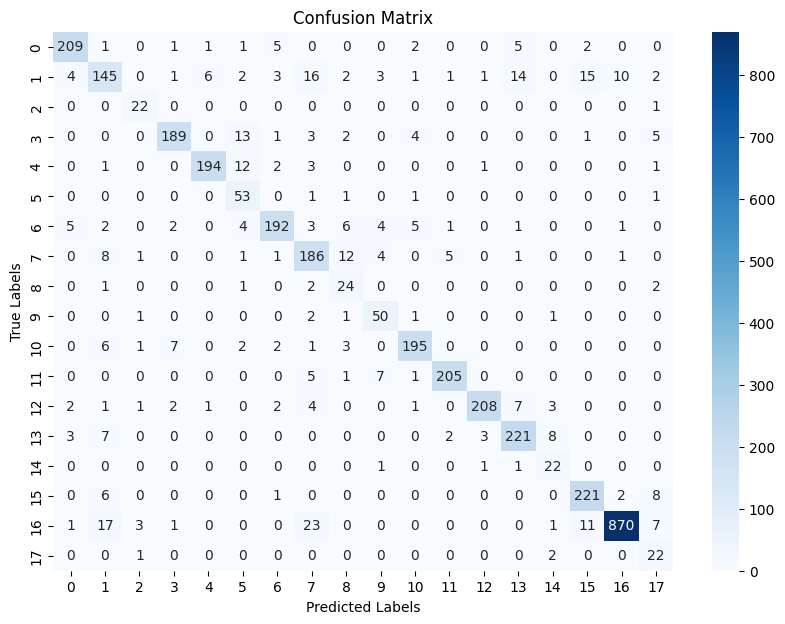

Best model, scaler, and label encoder saved.


In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(directory):
    features = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith('.npy'):
            file_path = Path(directory) / file
            data = np.load(file_path, allow_pickle=True).item()
            features.append(data['features'])
            labels.append(data['label'])
    return np.array(features), np.array(labels)

# Load training and testing data
train_data_dir = 'features_train'
test_data_dir = 'features_test_all'
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Expanded Hyperparameter tuning and model fitting
param_grid = {
    'C': [0.1, 0.5, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(svm.SVC(probability=True), param_grid, scoring='f1_macro', cv=5, n_jobs=4, verbose=3)
grid_search.fit(X_train, y_train)


# Get the best estimator and hyperparameters
best_clf = grid_search.best_estimator_
best_hyperparameters = grid_search.best_params_

# Print the best hyperparameters
print("Best hyperparameters:", best_hyperparameters)

# Predictions and metrics
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}\nPrecision (Weighted): {precision:.2f}\nRecall (Weighted): {recall:.2f}\nF1 Score (Weighted): {f1:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save the best model, scaler, and label encoder
dump(best_clf, 'svm_model_vicky.pkl')
dump(scaler, 'scaler_vicky.pkl')
dump(label_encoder, 'label_encoder_vicky.pkl')
print("Best model, scaler, and label encoder saved.")


### Load custom test set

In [ ]:
images_list = []
labels_list = []
    
input_folder_path = 'src/demo_dataset'
quality_list = os.listdir(input_folder_path)
    
for quality in quality_list:
    fruit_type = os.listdir(os.path.join(input_folder_path, quality))
    for fruit in fruit_type:
        #if 'Banana' in fruit:
        fruit_path = os.path.join(input_folder_path, quality, fruit)
        images = os.listdir(fruit_path)
        for image in images:
            image_path = os.path.join(fruit_path, image)
            print(image_path)
            i = io.imread(image_path)
            if len(i.shape) == 2 or (len(i.shape) == 3 and i.shape[2] == 1):
                print(f"Grayscale {image_path}")
                continue  
            images_list.append(image_path)
            # Check if the image name contains '_Good' or '_Bad' and assign the label accordingly
            if "_Good" in fruit or "_Bad" in fruit:
                labels_list.append(f"{fruit}")
            else:
                labels_list.append(f"{fruit}_Mixed")
                    
images_series = pd.Series(images_list, name="images_paths")
labels_series = pd.Series(labels_list, name="labels")
test_df_v2 = pd.concat([images_series, labels_series], axis=1)


### Extract features from the custom test set

In [ ]:
feature_save_path = "src/features_demo"
for index, row in test_df_v2.iterrows():
    # Load image
    image_path = row['images_paths']
    image = io.imread(image_path)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        continue    
    image = remove_background(image)
    image = resize(image, (256, 129), anti_aliasing=True)
    image = img_as_ubyte(image)
    
    # Extract features
    features = extract_all_features(image)

    # Extract label
    label = row['labels']

    # Save features and label to a file
    data = {
        'features': features,
        'label': label
    }
    feature_file_path = Path(feature_save_path) / f'{Path(image_path).stem}{label}_data.npy'
    np.save(feature_file_path, data)
    print(f'Data saved to: {feature_file_path}')

### Train SVM using the previous training data and evaluate using the custom test set

Accuracy: 0.18
Precision (Weighted): 0.19
Recall (Weighted): 0.18
F1 Score (Weighted): 0.17
              precision    recall  f1-score   support

           0       0.13      0.20      0.16        10
           1       0.05      0.20      0.08        10
           2       0.14      0.10      0.12        10
           3       0.25      0.10      0.14        10
           4       0.17      0.10      0.12        10
           5       0.18      0.20      0.19        10
           6       0.60      0.30      0.40        10
           7       0.18      0.30      0.22        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.29      0.20      0.24        10
          11       0.00      0.00      0.00        10
          12       0.33      0.20      0.25        10
          13       0.12      0.10      0.11        10
          14       0.00      0.00      0.00        10
          15       0.29      0.20      0.24

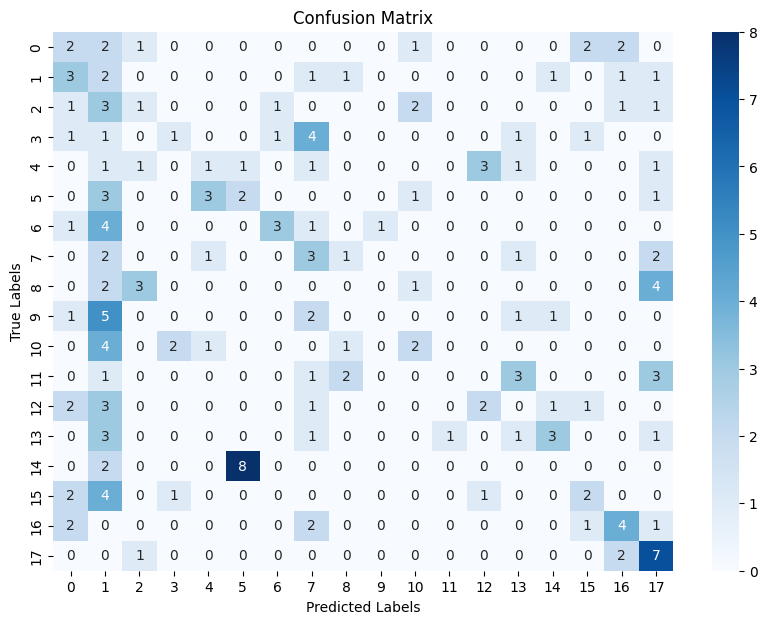

Best model, scaler, and label encoder saved.


In [53]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(directory):
    features = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith('.npy'):
            file_path = Path(directory) / file
            data = np.load(file_path, allow_pickle=True).item()
            features.append(data['features'])
            labels.append(data['label'])
    return np.array(features), np.array(labels)

# Load training and testing data
train_data_dir = 'features_train'
test_data_dir = 'features_test_v2'
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = svm.SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')
clf.fit(X_train, y_train) 


# Predictions and metrics
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}\nPrecision (Weighted): {precision:.2f}\nRecall (Weighted): {recall:.2f}\nF1 Score (Weighted): {f1:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save the best model, scaler, and label encoder
dump(best_clf, 'svm_model_final_v2.pkl')
dump(scaler, 'scaler_final_v2.pkl')
dump(label_encoder, 'label_encoder_final_v2.pkl')
print("Best model, scaler, and label encoder saved.")


### Discuss
The limited size of the test set has contributed to a lower degree of accuracy in the results. Furthermore, the evaluation metrics suggest that our initial model has overfitted to the training data. This overfitting is likely due to the dataset's quality, indicating that the model has learned the noise and specific patterns in the training set to an extent that it negatively impacts its performance on unseen data.

### DEMO

In [5]:
from joblib import load
from skimage import io
from skimage.transform import resize
from skimage.util import img_as_ubyte


# Function to load saved model, scaler, and label encoder
def load_model_scaler_encoder(model_path, scaler_path, encoder_path):
    model = load(model_path)
    scaler = load(scaler_path)
    label_encoder = load(encoder_path)
    return model, scaler, label_encoder

# Function to preprocess and predict new data
def predict_new_data(input_features, model, scaler, label_encoder):
    # Normalize features
    input_features_scaled = scaler.transform([input_features])

    # Predict using the model
    predictions = model.predict(input_features_scaled)
    # Decode predictions back to original labels
    decoded_predictions = label_encoder.inverse_transform(predictions)

    return decoded_predictions

# Load model, scaler, and label encoder
model, scaler, label_encoder = load_model_scaler_encoder('src/model/svm_model.pkl', 'src/model/scaler.pkl', 'src/model/label_encoder.pkl')
resize_shape=(256, 192)

# Example: Predicting new data
for i in range(1, 11):   
    image_path = f'src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p{i}.jpg'
    image = io.imread(image_path)
    image = remove_background(image)
    image = resize(image, resize_shape, anti_aliasing=True)
    image = img_as_ubyte(image)

    new_features = extract_all_features(image)
    predicted_labels = predict_new_data(new_features, model, scaler, label_encoder)
    print(f"Predicted label for {image_path}:", predicted_labels)

Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p1.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p2.jpg: ['Apple_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p3.jpg: ['Pomegranate_Bad']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p4.jpg: ['Pomegranate_Bad']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p5.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p6.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p7.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p8.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p9.jpg: ['Pomegranate_Mixed']
Predicted label for src/demo_dataset/Mixed Quality_Fruits/Pomegranate/p10.jpg: ['Pomegranate_Mixed']
